# Predicting Forest Fires in Algeria

## Introduction

Climate change has drastically increased the risk and extent of forest fires in several places around the world. Forest fires have numerous devastating effects such as the destruction of wildlife habitat and animal life, toxic gas emission to the atmosphere, infrastructure damage and could potentially cost human lives in the wake of a fire. Recognizing the potentially catastrophic effects of forest fires, it is vital to have some sort of early warning system that can help governmental agencies in forecasting forest fires.

<p float="left">
  <img src = "https://www.lifeinsuranceinternational.com/wp-content/uploads/sites/8/2019/02/shutterstock_710588224.jpg" width = "300"/>
  <img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQkiv3dvAtycEW-ZvEomKQXvL38bNuSKx1sOQ&usqp=CAU" width = "350" height = 265/>
  <img src = "https://i.natgeofe.com/n/77462492-ea41-41fe-9c07-296dc330181f/80133.jpg" width = "260"/>
</p>

With that motivation in mind, this project aims to develop a k-nearest neighbours machine learning model that can predict whether or not a forest fire will occur based on various weather metrics. Our dataset is obtained from <https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++#>. This is a grouped dataset that contains observations from two different regions of Algeria, namely the Bejaia region in the northeast and the Siddi Bel-Abbes region in the northwest.

The dataset contains 14 columns:
* Day (day)
* Month (month): June to September
* Year (year): 2012
* Temperature: maximum temperature at noon, in degree Celsius (range: 22 -40)
* Relative humidity (RH): relative humidity in % (range: 21 - 90)
* Windspeed (Ws): in speed in km/h (range: 6 - 29)
* Rain amount (Rain): rain amount in a day, in milimeters (mm) (range: 0 - 16.8)
* Fine Fuel Moisture Code (FFMC) index from the FWI system (range: 28.6 - 92.5)
* Duff Moisture Code (DMC) index from the FWI system (range: 1.1 - 65.9)
* Drought Code (DC) index from the FWI system (range: 7 - 220.4)
* Initial Spread Index (ISI) index from the FWI system (range: 0 - 18.5)
* Buildup Index (BUI) index from the FWI system (range: 1.1 - 68)
* Fire Weather Index (FWI) Index (range: 0 - 31.1)
* Classes: fire/not fire

## Preliminary Exploratory Data Analysis

In [27]:
library(tidyverse)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

### Reading & Wrangling our dataset from the web into R

* Due to there being 2 datasets in a single .csv file, we read them separately and then merged both of them into a single dataframe called "forest_fires".
* Since there was a missing value in one of the rows, the na.omit() function was used to get rid of that row.  
* The columns which had numerical values but were of a different type were converted back into numerical variables.
* The region column was created to identify which observation belonged to which region.   
* The Class column will be are target variable for this analysis therefore it was converted into a factor variable.
* Data was wrangled to obtain only the columns/variables we will be using for our analysis.

In [3]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv"

Bej_data <- read_csv(url, skip = 1, n_max = 122)

SB_data <- read_csv(url, skip = 126) %>% 
    na.omit() %>% 
    mutate(DC = as.numeric(DC),
           FWI = as.numeric(FWI))

forest_fires <- rbind(Bej_data, SB_data) %>% 
    mutate(day = as.numeric(day),
           month = as.numeric(month),
           Classes = as_factor(Classes))

forest_fires <- cbind(region = (c(rep("Bejaia", 122), rep("Sidi-Bel Abbes", 121))), forest_fires) %>% 
    select(region:Rain, FWI, Classes)

forest_fires

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_double(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_double(),
  Classes = col_character()
)

Parsed with column specification:
cols(
  day = col_character(),
  month = col_character(),
  year = col_double(),
  Temperature = col_double(),
  RH = col_double(),
  Ws = col_double(),
  Rain = col_double(),
  FFMC = col_double(),
  DMC = col_double(),
  DC = col_character(),
  ISI = col_double(),
  BUI = col_double(),
  FWI = col_character(),
  Classes = col_character()
)

Warning message:
“1 parsing failure.
row col   expected     actual                                                                                                       file
 44  -- 14 columns 13 columns 'https://archive.ics.uci.edu/ml/machine-lear

region,day,month,year,Temperature,RH,Ws,Rain,FWI,Classes
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Bejaia,1,6,2012,29,57,18,0.0,0.5,not fire
Bejaia,2,6,2012,29,61,13,1.3,0.4,not fire
Bejaia,3,6,2012,26,82,22,13.1,0.1,not fire
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Sidi-Bel Abbes,28,9,2012,27,87,29,0.5,0.2,not fire
Sidi-Bel Abbes,29,9,2012,24,54,18,0.1,0.7,not fire
Sidi-Bel Abbes,30,9,2012,24,64,15,0.2,0.5,not fire


### Summarizing the Training Data

* Here, we have split 75% of the data into a training set and 25% into the test set.
* We also used set.seed() for reproducible results as initial_split randomly samples from the dataframe.

In [4]:
set.seed(1234)
ff_split <- initial_split(forest_fires, prop = 0.75, strata = Classes)
ff_train <- training(ff_split)
ff_test <- testing(ff_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.
* In the code block below, the table reports the number of observations in each class (not fire or fire).

In [5]:
n_per_class <- ff_train %>% 
    group_by(Classes) %>% 
    summarize(n = n())

n_per_class

`summarise()` ungrouping output (override with `.groups` argument)



Classes,n
<fct>,<int>
not fire,80
fire,103


* In the code block below, the table reports the number of observations in each class for each region.

In [6]:
n_per_class_region <- ff_train %>% 
    group_by(region, Classes) %>% 
    summarize(n = n())

n_per_class_region

`summarise()` regrouping output by 'region' (override with `.groups` argument)



region,Classes,n
<chr>,<fct>,<int>
Bejaia,not fire,45
Bejaia,fire,49
Sidi-Bel Abbes,not fire,35
Sidi-Bel Abbes,fire,54


* In the code block below, the table reports the means of the predictor variables for all regions.

In [7]:
avg_pred_vals <- ff_train %>% 
    select(-day, -month, -year, -Classes, -region) %>% 
    map_df(mean, na.rm = TRUE)

avg_pred_vals

Temperature,RH,Ws,Rain,FWI
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
32.23497,62.43716,15.55738,0.6612022,6.839891


* In the code block below, the two tables report the means of the predictor variables for the each region.

In [8]:
bej_avg_pred_vals <- ff_train %>% 
    filter(region == "Bejaia") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Bejaia"))

sid_avg_pred_vals <- ff_train %>% 
    filter(region == "Sidi-Bel Abbes") %>%
    select(-day, -month, -year, -Classes) %>% 
    map_df(mean, na.rm = TRUE) %>% 
    mutate(region = c("Sidi-Bel Abbes"))

bej_avg_pred_vals
sid_avg_pred_vals

Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(.x[[i]], ...):
“argument is not numeric or logical: returning NA”


region,Temperature,RH,Ws,Rain,FWI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Bejaia,31.57447,67.59574,16.1383,0.6361702,5.844681


region,Temperature,RH,Ws,Rain,FWI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sidi-Bel Abbes,32.93258,56.98876,14.94382,0.6876404,7.891011


### Visualizing the Training Data

* The histograms depicted below represent the distributions of each predictor variable.
* Each histogram shows the distribution for each region.

Warning message:
“'switch' is deprecated.
Use 'strip.position' instead.
See help("Deprecated")”


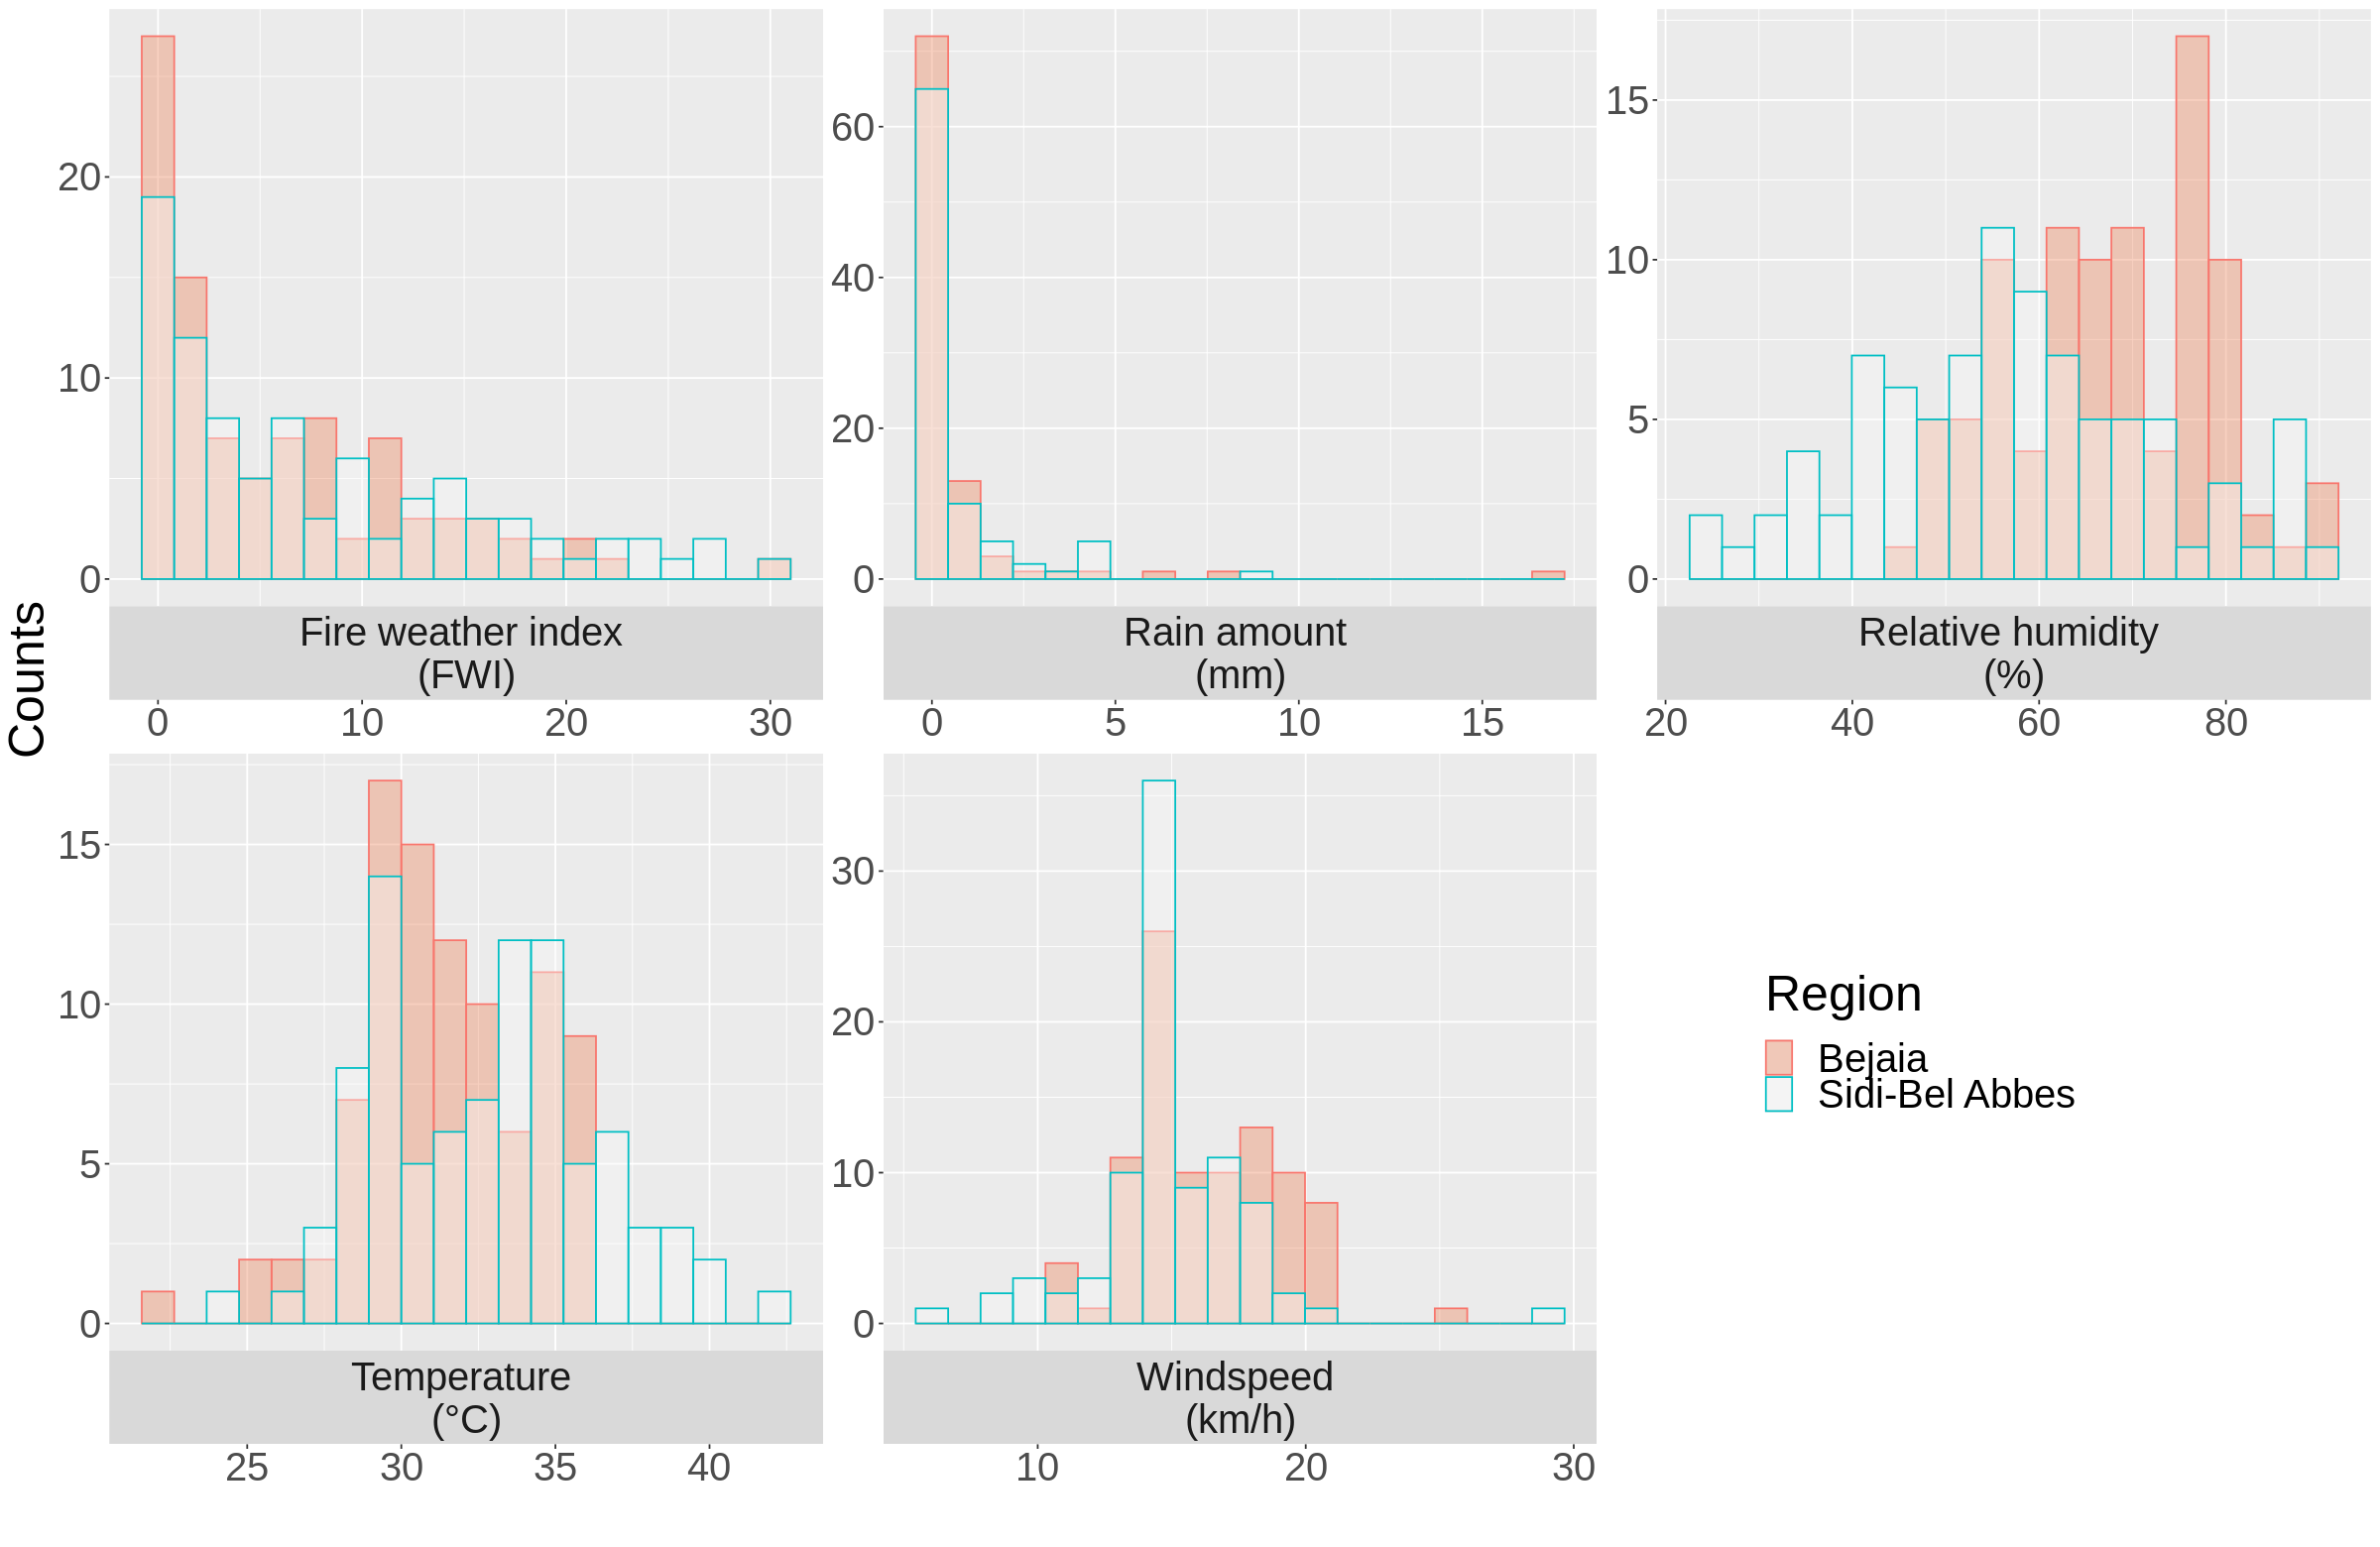

In [28]:
options(repr.plot.width = 20, repr.plot.height = 13)

a <- ff_train %>%
    pivot_longer(cols = Temperature:FWI,
                 names_to = "predictors",
                 values_to = "values")

predictor_labels <- c(Temperature = "Temperature \n(°C)", 
                   RH = "Relative humidity \n(%)", 
                   Ws = "Windspeed \n(km/h)",
                   Rain = "Rain amount \n(mm)", 
                   FWI = "Fire weather index \n(FWI)")

distribution_plot <- a %>%
    ggplot(aes(x = values, fill = region, colour = region)) + 
    geom_histogram(alpha = 0.4, position = 'identity', bins = 20) +
    labs(x = "", y = "Counts", fill = "Region", colour = "Region") +
    facet_wrap(vars(predictors), 
               scales = "free",
               switch = "x",
               labeller = labeller(predictors = predictor_labels)) +
    theme(strip.text.y.left = element_text(angle = 0),
          legend.position = c(0.80, 0.23),
          text = element_text(size = 30)) +
    scale_fill_brewer(palette = "RdBu") # To see more colorblind friendly pallete: display.brewer.all(colorblindFriendly = T)


distribution_plot

## Methods

The Algerian Forest Fire dataset provides us with two different regions to account for: Bejaia and Sidi-Bel Abbes. Our team decided to combine the two regions to create more comprehensive data to better equip our model, while using 75% and 25% for the training and testing set, respectively. We then decided to select the variables that seemed to be major predictors of whether a specific forest region has the potential to experience a forest fire, namely: Temperature, Relative Humidity (RH), Wind Speed (WS), Rain Amount, and Fire Weather Index. Consequently, we decided against choosing Fine Fuel Moisture Code (FFMC), Duff Moisture Code (DMC), Drought Code (DC), Initial Spread Index (ISI), and Buildup Index (BI) as the predictor variables due to their calculation intermediacy and dependence on other variables. Finally, we created a set of colour-coded histograms for each predictor variable where the colours depicted the regions to assist in the visualization of the distributions of the variability among the selected predictors.

## Expected Outcomes and Significance

* We expect to produce a decently accurate k-nearest-neighbour model to predict whether a forest fire would occur based on our chosen weather metrics as predictors. Furthermore, our aim is to make the prediction data useful with regards to reducing the number of Forest Fires within the Algerian region by learning how each of the selected predictor variables interacts with one another; thus, minimizing the forest fire that can be predicted beforehand. Additionally, this analysis could potentially help us to answer future questions concerning the role of climate and environmental variation that affects our ecological succession.
* A successful completion of this model could help the authorities in predicting forest fires, preventing damages to human lives, infrastructure and the environment as a whole. In addition, through this project, we can obtain more insight into whether certain weather metrics/conditions are significant in successfully predicting the occurrence of forest fires.
* Some future questions and researches that our analysis could lead to are as follows:
<ol>
<li>Can we use a better algorithm to predict forest fire? If so, which one would be the best for this application?</li>
<li>Can a model trained with data from a country/climate region predict whether forest fires would occur if presented with an observation from another country/climate region? In other words, can we extrapolate?</li>
<li>Are the current weather metrics good in predicting forest fires (Fire Weather Index System)? Can we develop a better forest fire system or better ways to collect the data/metrics?</li>
</ol>